# Post-training Investigation

This notebook uses different methods to assess the quality of generated EEG data. By doing so, we will inform ourselves of possible improvement that can be made to the WGAN's arch to generate more realisitc-looking data.

In [1]:
# imports
%reload_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from scipy.signal import sosfilt, butter
os.environ['KERAS_BACKEND'] = 'torch'
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '0'
from scipy.signal import welch
from scipy.stats import entropy, skew, kurtosis
from scipy.linalg import sqrtm
from ot import sliced_wasserstein_distance

import torch
import keras
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from src.EEGModalNet.models.WGAN import WGAN_GP
from src.EEGModalNet.utils import CustomModelCheckpoint, StepLossHistory
from scipy.stats import wasserstein_distance
import mne

# helper functions
def plot_segment(x, x_gen, sub, seg, duration=1024, db=False):
    x1 = x[sub*60:(sub+1)*60].flatten()
    x_gen1 = x_gen[sub*60:(sub+1)*60].flatten()
    plt.figure(figsize=(20, 2))
    segment = x1[seg*duration:(seg+1)*duration]
    segment_gen = x_gen1[seg*duration:(seg+1)*duration]
    plt.plot(segment, label='real')
    plt.plot(segment_gen, label='fake')
    plt.legend()
    plt.xlim(0, duration)
    plt.show()
    f, Pxx = welch(segment, fs=128, nperseg=256)
    f, Pxx_gen = welch(segment_gen, fs=128, nperseg=256)
    if db:
        Pxx = 10*np.log10(Pxx)
        Pxx_gen = 10*np.log10(Pxx_gen)
    plt.figure(figsize=(5, 5))
    plt.plot(f, Pxx, label='real')
    plt.plot(f, Pxx_gen, label='fake')
    plt.legend()
    plt.xlim(0, 50)
    plt.grid()
    plt.show()

def plot_onebyone(x_gen, x, n_seg=5, ch=0, time_dim=512, start_from=0, figsize=(10, 5)):
    for i in range(start_from, n_seg+start_from):
        plt.figure(figsize=figsize)
        plt.plot(x_gen[i, :time_dim, ch], label='generated')
        plt.plot(x[i, :time_dim, ch], label='real')
        plt.xlim(0, time_dim)
        plt.legend()
        plt.show()

def plot_overlap(x, n_seg=5, ch=0, time_dim=512, start_from=0, show=True):
    plt.figure(figsize=(20, 2))
    for i in range(start_from, start_from+n_seg):
        plt.plot(x[i, :time_dim, ch])
    plt.xlim(0, time_dim)
    if show:
        plt.show()

def plot_psd(x, fmin=1, fmax=60, n_fft=512, label='real', show=True, db=True):
    psd, freq = mne.time_frequency.psd_array_welch(x.squeeze().flatten(0, 1).numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft)
    if db:
        psd = 10*np.log10(psd)
    plt.plot(freq, psd, label=label)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

def plot_2d_components(x, x_gen, ch=0, method='tsne'):
    x, x_gen = x[:, :, [ch]], x_gen[:, :, [ch]]
    sample_len = x.shape[0]
    x_flat = x.mean(axis=2)
    x_flat_hat = x_gen.mean(axis=2)
      
    x_flat_final = np.concatenate((x_flat, x_flat_hat), axis = 0)
    if method == 'tsne':
        tsne = TSNE(n_components=2, verbose=1, perplexity=20, method='barnes_hut', n_jobs=-1)
    if method == 'pca':
        tsne = PCA(n_components=2)
    tsne_results = tsne.fit_transform(x_flat_final)
        
    # Plotting
    f, ax = plt.subplots(1)
    colors = ["red" for i in range(sample_len)] + ["blue" for i in range(sample_len)]
        
    plt.scatter(tsne_results[:sample_len, 0], tsne_results[:sample_len,1], 
                c = colors[:sample_len], alpha = 0.2, label = "Original")
    plt.scatter(tsne_results[sample_len:, 0], tsne_results[sample_len:, 1], 
                c = colors[sample_len:], alpha = 0.2, label = "Synthetic")

    ax.legend()
    plt.title('t-SNE plot')
    plt.xlabel('x-tsne')
    plt.ylabel('y_tsne')
    plt.show()

# critic performance
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def print_D_performance(x, sub, model, pos):
    return sigmoid(model.critic(x.float().to('mps'), sub.to('mps'), pos.to('mps')).mean().item())

def plot_real_fake_hist(x, x_gen, model):
    real_scores = model.critic(x.float().to('mps'), torch.tensor(sub).to('mps')).cpu().detach().numpy().flatten()
    fake_scores = model.critic(x_gen.float().to('mps'), torch.tensor(sub).to('mps')).cpu().detach().numpy().flatten()
    plt.hist(real_scores, bins=20, alpha=0.5, label='real')
    plt.hist(fake_scores, bins=20, alpha=0.5, label='fake')
    # plt.xlim(4, 12)
    plt.legend()

def find_channel_ids(dataarray, ch_names):
    return [i for i, ch in enumerate(dataarray.channel.to_numpy()) if ch in ch_names]

/opt/homebrew/Caskroom/miniforge/base/envs/EEGModalNet/lib/python3.11/site-packages/mne/externals/tempita/__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


## DATA

In [9]:
# Real DATA
# channels = ['O1', 'O2', 'Fp1', 'Fp2', 'C1', 'C2', 'P1', 'P2']
channels = ['Fp1', 'Fp2']
filtering = True
time_dim = 512
n_subject = 100
# exclude_sub_ids=['sub-010257', 'sub-010044', 'sub-010266']  # TODO: inspect other channels' data and update this subjects list
exclude_sub_ids = None

# data
data_path = 'data/LEMON_data/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5'
xarray = xr.open_dataarray(data_path, engine='h5netcdf')

x = xarray.sel(subject=xarray.subject[:n_subject], channel=channels)
if exclude_sub_ids is not None:
    x = x.sel(subject=~x.subject.isin(exclude_sub_ids))
    n_subject = len(x.subject)
    sub_ids = xarray.subject[:n_subject].to_numpy()
x = x.to_numpy()

# if filtering:
#     sos = butter(4, 1, btype='high', fs=128, output='sos')
#     x = sosfilt(sos, x, axis=-1)
# x = torch.tensor(x).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)
# sub = torch.tensor(np.arange(0, n_subject).repeat(x.shape[0]//n_subject)[:, np.newaxis])

# ch_ind = find_channel_ids(xarray, channels)
# pos = torch.tensor(xarray.ch_positions[ch_ind][None].repeat(x.shape[0], 0))
# data = {'x': x, 'sub': sub, 'pos': pos}
# # signal = x.squeeze().numpy()

In [3]:
latent_dim = 64
wgan_gp = WGAN_GP(time_dim=time_dim, feature_dim=len(channels), latent_dim=latent_dim, n_subjects=n_subject, use_sublayer_generator=True,
                  use_sublayer_critic=False, use_channel_merger_g=True, use_channel_merger_c=True, kerner_initializer=keras.initializers.HeNormal(),  # glorot_uniform
                  interpolation='bilinear')

### Notch Filter

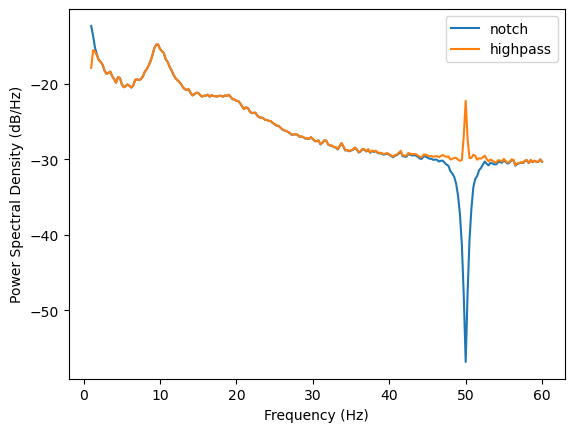

In [35]:
# notch filter
from scipy.signal import iirnotch, tf2sos, sosfiltfilt

def plot_psd(x, c=0, fmin=1, fmax=60, n_fft=512, label='real', show=True, db=True):
    psd, freq = mne.time_frequency.psd_array_welch(x[:, c, :].flatten(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft, verbose=0)
    if db:
        psd = 10*np.log10(psd)
    plt.plot(freq, psd, label=label)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()

fs = 128
f0 = 50
Q = 30
w0 = f0 / (fs / 2)  # Normalized Frequency
b, a = iirnotch(w0, Q)

sos = tf2sos(b, a)
x1 = sosfiltfilt(sos, x, axis=-1)

sos = butter(4, 1, btype='high', fs=128, output='sos')
x2 = sosfiltfilt(sos, x, axis=-1)

plot_psd(x1, fmax=60, label='notch', show=False)
plot_psd(x2, fmax=60, label='highpass', show=False)

plt.legend()
plt.show()

## Feature Extraction

Quantifying the similarity between X and X_gen

In [12]:
## feature extraction
# time domain features
def time_domain_features(x, axis=1):
    mean = np.mean(x, axis=axis)
    std = np.std(x, axis=axis)
    skewness = skew(x, axis=axis)  # equivalent to ((x - mean)**3).mean() / std**3 
    kurtosis_ = kurtosis(x, axis=axis)  # equivalent to ((x - mean)**4).mean() / std**4 when fisher=False
    rms = np.sqrt(np.mean(signal**2, axis=1))
    return np.stack([mean, std, skewness, kurtosis_, rms], axis=1)

# hjorth parameters
def hjorth_parameters(signal, axis=1):
    # Activity
    activity = np.var(signal, axis=axis)

    # Mobility
    first_derivative = np.diff(signal, axis=axis)
    mobility = np.sqrt(np.var(first_derivative, axis=axis) / activity)

    # Complexity
    second_derivative = np.diff(first_derivative, axis=axis)
    complexity = np.sqrt(np.var(second_derivative, axis=axis) / np.var(first_derivative, axis=axis)) / mobility

    return np.stack([activity, mobility, complexity], axis=1)

# Spectral features
def spectral_features(signal):
    f, Pxx = welch(signal, fs=128, nperseg=512)
    total_power = np.sum(Pxx, axis=1)
    delta = np.sum(Pxx[:, (f >= 0.25) & (f < 4)], axis=1) / total_power
    theta = np.sum(Pxx[:, (f >= 4) & (f < 8)], axis=1) / total_power
    alpha = np.sum(Pxx[:, (f >= 8) & (f < 13)], axis=1) / total_power
    beta = np.sum(Pxx[:, (f >= 13) & (f <= 30)], axis=1) / total_power
    gamma = np.sum(Pxx[:, (f > 30) & (f <= 50)], axis=1) / total_power
    pxx_entropy = entropy(Pxx, axis=1)
    return np.stack([delta, theta, alpha, beta, gamma, pxx_entropy], axis=1)

# create a feature matrix
def creat_feature_matrix(signal):
    time_features = time_domain_features(signal)
    hjorth = hjorth_parameters(signal)
    spectral = spectral_features(signal)
    return np.concatenate([time_features, hjorth, spectral], axis=1)

# Fréchet Inception Distanc (FID)
def compute_fid(x_features, y_features):
    # Mean and covariance
    mean1, cov1 = x_features.mean(axis=0), np.cov(x_features, rowvar=False)
    mean2, cov2 = y_features.mean(axis=0), np.cov(y_features, rowvar=False)
    # Mean difference
    mean_diff = np.sum((mean1 - mean2)**2)
    
    # Covariance square root
    covmean = sqrtm(cov1 @ cov2)
    
    # Numerical stability
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    # FID formula
    fid = mean_diff + np.trace(cov1 + cov2 - 2 * covmean)
    return fid

In [9]:
# compute FID
real_f = hjorth_parameters(signal)
gen_f = hjorth_parameters(signal_gen)
fid = compute_fid(real_f, gen_f)
distance = sliced_wasserstein_distance(real_f, gen_f)

print(f'FID on hjorth parameters: {fid:.5f}',
      f'Wasserstein distance on hjorth parameters: {distance:.5f}')

FID on hjorth parameters: 0.08006 Wasserstein distance on hjorth parameters: 0.16834


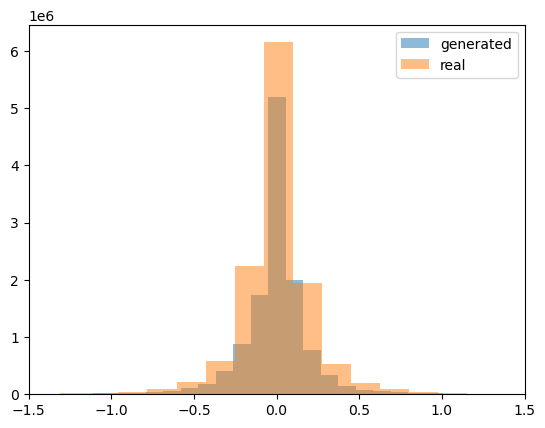

In [10]:
# Wasserstein Distance
wdr = wasserstein_distance(signal_gen.flatten(), signal.flatten())
# visualize amplitude histograms
plt.hist(x_gen.flatten(), bins=100, alpha=0.5, label='generated')
plt.hist(x.flatten(), bins=100, alpha=0.5, label='real')
plt.xlim(-1.5, 1.5)
plt.legend()
plt.show()

## Model comparison

In [ ]:
ls = range(20, 1300, 20)
fids = np.zeros([len(ls), 3])

for i in ls:
    model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras'
    print(f'Epoch {i}')
    wgan_gp.load_weights(model_path)

    x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                                pos).cpu().detach()

    signal_gen = x_gen.squeeze().numpy()

    # compute FID on different features
    for j, func in enumerate([hjorth_parameters, spectral_features, time_domain_features]):
        real_f = func(signal)
        gen_f = func(signal_gen)
        fid = compute_fid(real_f, gen_f)
        fids[i//20-1, j] = fid

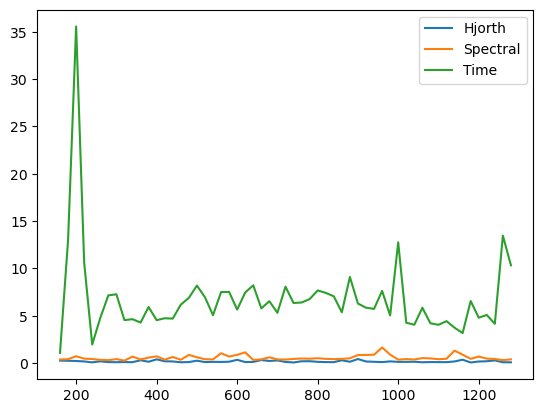

In [69]:
plt.plot(ls[7:], fids[7:, 0], label='Hjorth')
plt.plot(ls[7:], fids[7:, 1], label='Spectral')
plt.plot(ls[7:], fids[7:, 2], label='Time')
plt.legend()

## Using best model for downstream task

In [151]:
from sklearn.model_selection import GroupShuffleSplit, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Gender labels
y = xarray.gender[~xarray.subject.isin(exclude_sub_ids)]
y -= 1
y = y.reshape(-1, 1).repeat(x.shape[0]//n_subject, 1).flatten()

In [152]:
# Model
# # intermediate feature extraction using the best model ls[np.argmin(fids.sum(axis=1))]  # 160
# i = 1260
# model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_best_gloss.model.keras'
# wgan_gp.load_weights(model_path)

# X features
f_extractor = keras.Model(wgan_gp.critic.model.layers[0].input, wgan_gp.critic.model.layers[10].output)  # intermediate layer
features = f_extractor(x.float()).cpu().detach().numpy()

In [153]:
# Classifier
cv_g = GroupShuffleSplit(n_splits=10, test_size=0.2)

pipe = Pipeline(steps=[
    ('zerovar', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    ('clf', SVC(max_iter=1000000, kernel='sigmoid', class_weight='balanced')),
])

scores_g = cross_val_score(pipe, features, y, cv=cv_g, groups=sub, n_jobs=-1)
print(f'Accuracy: {np.array(scores_g).mean() * 100:.2f}%', f'±{np.array(scores_g).std() * 100:.2f}%')

Accuracy: 49.67% ±1.27%


## Visualize intermediate neurons activations

In [4]:
# helper functions for plotting
def plot_neurons_act(features, across_batch=False, from_to=(20, 40), batch=0, xlim=1024):
    plt.figure(figsize=(20, 2))
    if len(features.shape) == 3:
        if across_batch:
            for i in range(from_to[0], from_to[1]):
                plt.plot(features[i, :, 0])
        else:
            for i in range(0, features.shape[2]):
                plt.plot(features[batch, :, i])

    if len(features.shape) == 2:
        for i in range(from_to[0], from_to[1]):
            plt.plot(features[i, :])
    plt.xlim(0, xlim)
    plt.show()
i = 1260

(11940, 512, 1)


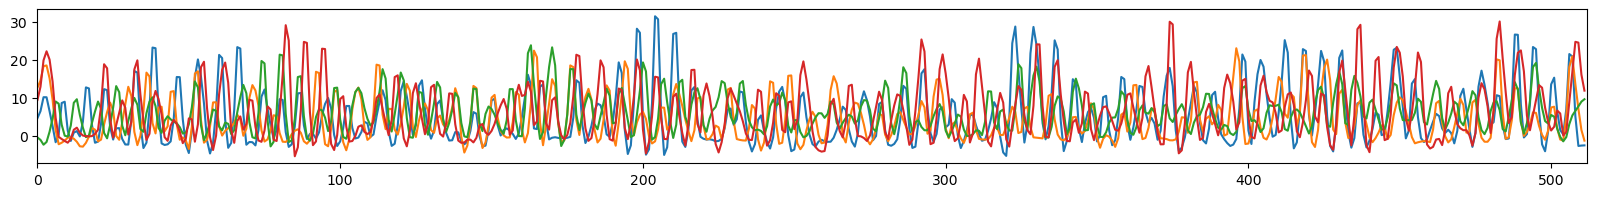

In [139]:
model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras'
wgan_gp.load_weights(model_path)

generator = wgan_gp.generator
latent_dim=64
features = keras.Model(generator.model.layers[0].input, generator.model.layers[5].output)(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std())).cpu().detach().numpy()
print(features.shape)
plot_neurons_act(features, across_batch=True, from_to=(1000, 1004), xlim=features.shape[1])

## Critics performance

In [ ]:
critic_performances_real = {}
critic_performances_gen = {}

for i in range(20, 1840, 20):
    dir = Path(f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras')
    wgan_gp.load_weights(dir)
    x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                              pos).cpu().detach()
    print(f'>>>>>> {dir.stem.split(".")[2][5:]}')
    critic_performances_real[dir.stem.split(".")[2][5:]] = print_D_performance(x, sub, wgan_gp)
    critic_performances_gen[dir.stem.split(".")[2][5:]] = print_D_performance(x_gen, sub, wgan_gp)

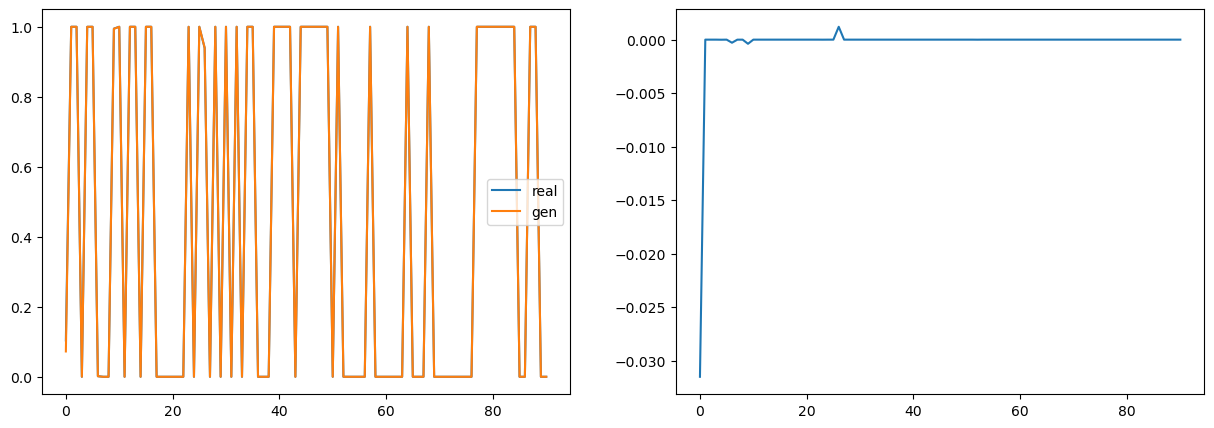

In [146]:
# concatenate critic performances
critic_performances = pd.concat([pd.Series(critic_performances_real), pd.Series(critic_performances_gen)], axis=1)

# difference in critic performances
critic_performances['diff'] = critic_performances.iloc[:, 1] - critic_performances.iloc[:, 0]
# plot critic performances
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(list(critic_performances_real.values()), label='real')
axes[0].plot(list(critic_performances_gen.values()), label='gen')
axes[1].plot(critic_performances['diff'].values, label='diff')
axes[0].legend()
plt.show()

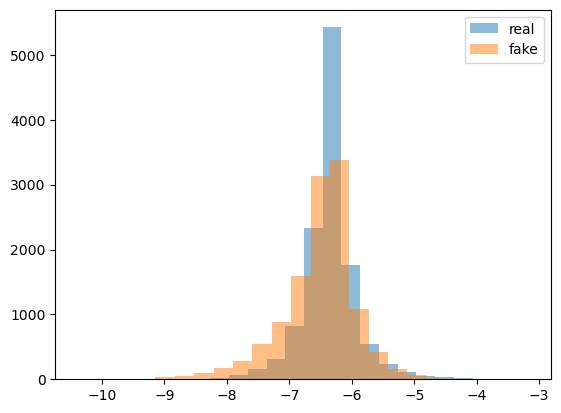

In [12]:
## histogram of the critic outputs
i = 140
dir = Path(f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras')
wgan_gp.load_weights(dir)
x_gen = wgan_gp.generator(keras.random.normal((len(x), 64), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
                            pos).cpu().detach()

plot_real_fake_hist(x, x_gen, wgan_gp)

## Visual Inspection of X_gen vs. X

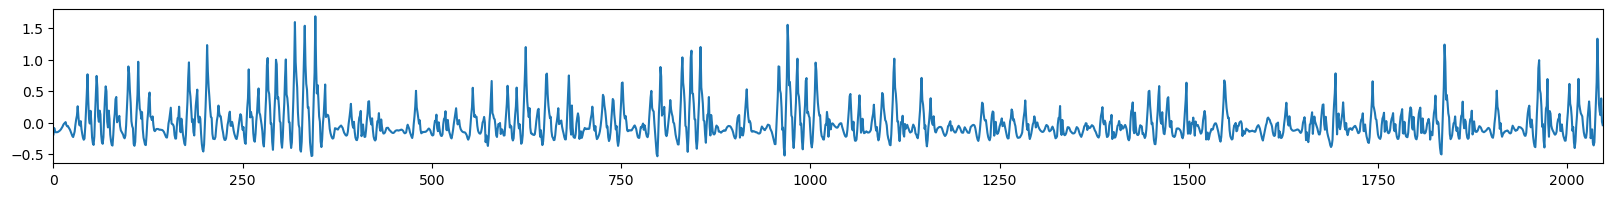

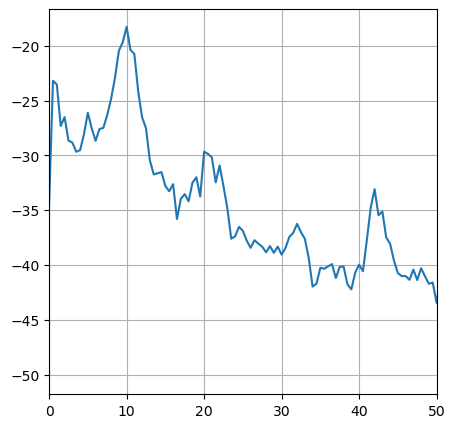

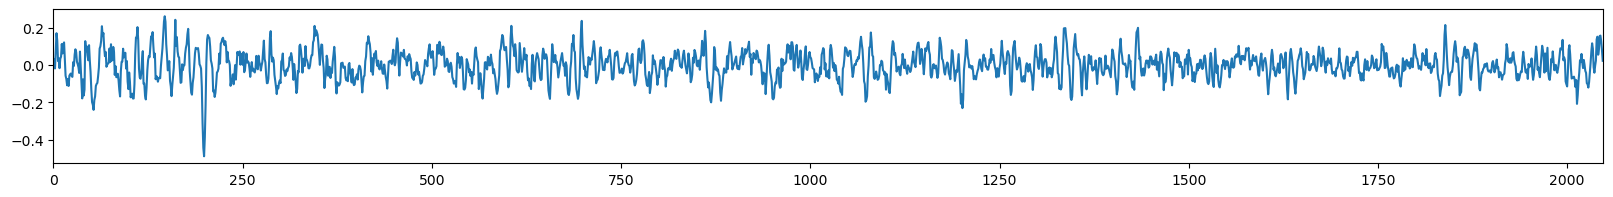

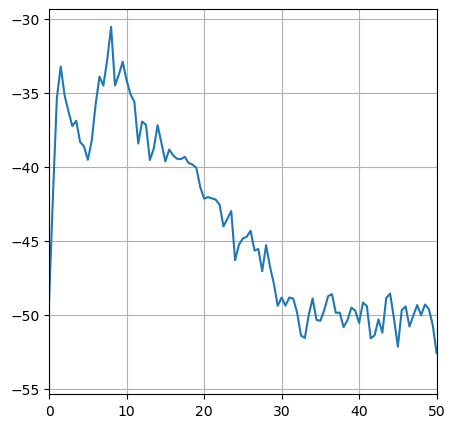

In [ ]:
sub = 2
d = 2*1024
s = 10

plot_segment(x_gen, sub, s, db=True)
plot_segment(x, sub, s, d, db=True)

## Model & Training

In [16]:
keras.mixed_precision.set_global_policy('mixed_float16')

In [3]:
# 2. MODEL and Plot generated data by the model before training
latent_dim = 64
time_dim = 512
wgan_gp = WGAN_GP(time_dim=time_dim, feature_dim=len(channels), latent_dim=latent_dim, n_subjects=n_subject, use_sublayer_generator=True,
                  use_sublayer_critic=False, use_channel_merger_g=True, use_channel_merger_c=True, kerner_initializer='random_normal',  # glorot_uniform
                  interpolation='bilinear')
# x_gen = wgan_gp.generator(keras.random.normal((len(x), latent_dim), mean=x.mean(), stddev=x.std()), torch.tensor(sub).to('mps'),
#                           pos).cpu().detach()

In [4]:
torch.cuda.empty_cache() # clear GPU memory before training
step_losses_history = StepLossHistory()

# 3. TRAINING
wgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.00005, beta_1=0.5, beta_2=0.9),
                g_optimizer=keras.optimizers.Adam(0.0005, beta_1=0.5, beta_2=0.9),
                gradient_penalty_weight=5.0)

In [ ]:
# training
batch_size = 128
output_path = 'logs/test_6.1.2025'
# early stopping callback
callbacks = [keras.callbacks.EarlyStopping(monitor='g_loss', mode='min', patience=500),
             step_losses_history,
             CustomModelCheckpoint(output_path, save_freq=10),
             keras.callbacks.CSVLogger(output_path + 'history.csv')]
history = wgan_gp.fit(data, epochs=7, batch_size=batch_size, callbacks=callbacks, shuffle=True)

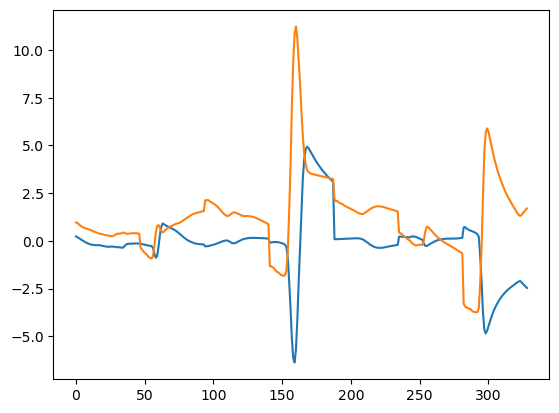

In [23]:
# plot step losses
plt.plot(step_losses_history.step_losses['g_loss'], label='g_loss')
plt.plot(step_losses_history.step_losses['d_loss'], label='d_loss')

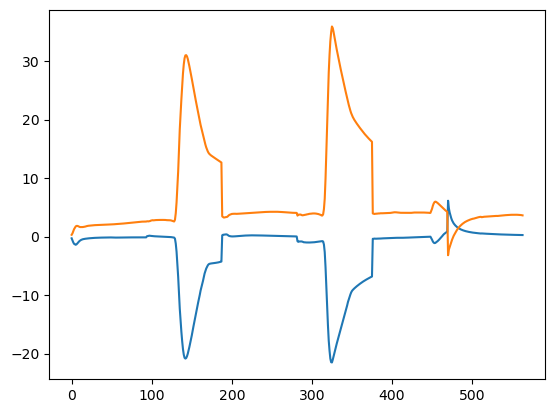

In [28]:
# plot step losses
plt.plot(step_losses_history.step_losses['g_loss'], label='g_loss')
plt.plot(step_losses_history.step_losses['d_loss'], label='d_loss')

### model performance

In [ ]:
from src.EEGModalNet.models.WGAN import WGAN_GP
latent_dim = 64
model = WGAN_GP(time_dim=512, feature_dim=len(channels),
                latent_dim=latent_dim, n_subjects=202,
                use_sublayer_generator=True,
                use_sublayer_critic=False,
                use_channel_merger_g=True,
                use_channel_merger_c=True,
                kerner_initializer=keras.initializers.HeNormal(),
                interpolation='bilinear')

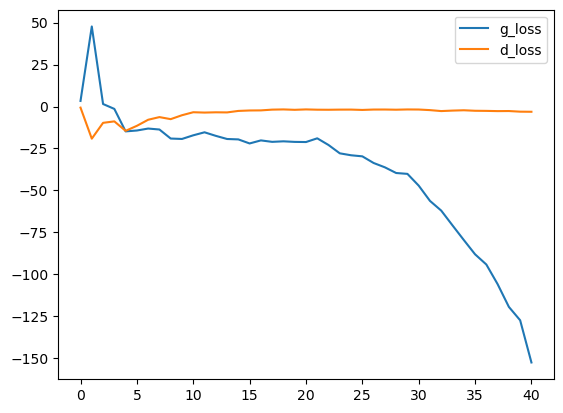

In [4]:
# load model and history
output_path = f'logs/test_06.01.2025_epoch_40.model.keras'
model.load_weights(output_path)

history = pd.read_csv('logs/test_06.01.2025.csv')
plt.plot(history['g_loss'], label='g_loss')
plt.plot(history['d_loss'], label='d_loss')
plt.legend()

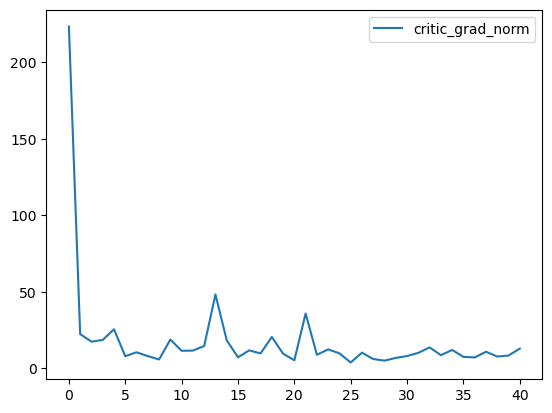

In [8]:
plt.plot(history['critic_grad_norm'], label='critic_grad_norm')
plt.legend()

In [14]:
l = 1024
x_gen = model.generator(keras.random.normal((l, 64), mean=x.mean(), stddev=x.std()), sub[:l].to('mps'),
                            pos[:l].to('mps')).cpu().detach()

In [ ]:
signal_gen = x_gen.squeeze().numpy()
fids = {}
for j, func in enumerate([hjorth_parameters, spectral_features, time_domain_features]):
    real_f = func(signal)
    gen_f = func(signal_gen)
    print(f'FID on {func.__name__}: {compute_fid(real_f, gen_f)}')

In [22]:
signal_gen = x_gen.squeeze().numpy()
fids = {}
for j, func in enumerate([hjorth_parameters, spectral_features, time_domain_features]):
    real_f = func(signal)
    gen_f = func(signal_gen)
    print(f'FID on {func.__name__}: {compute_fid(real_f, gen_f)}')

FID on hjorth_parameters: 0.6178601634358091
FID on spectral_features: 0.19823238199844231
FID on time_domain_features: 18.227519707415546


#### compared in frequency domain

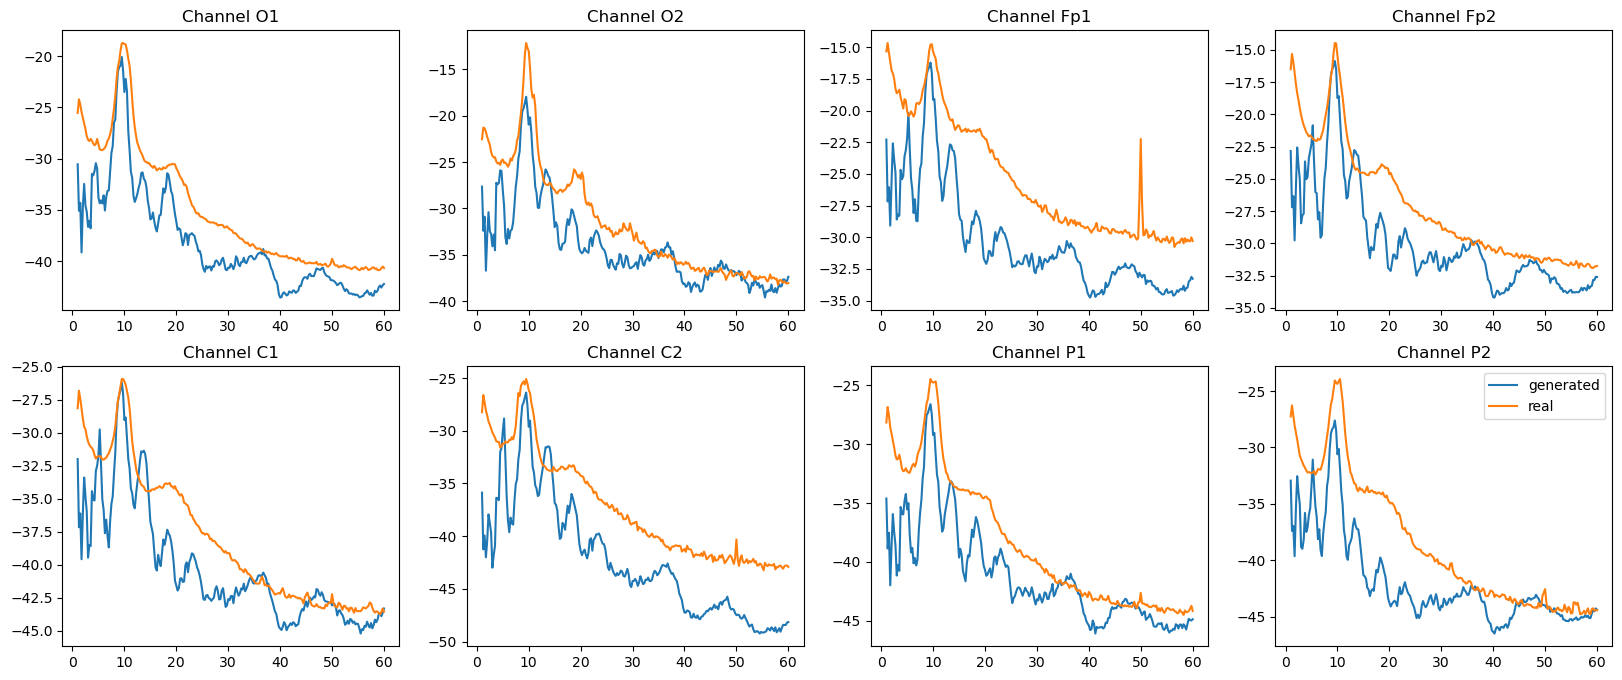

In [15]:
def plot_psd(x, c=0, fmin=1, fmax=60, n_fft=512, label='real', show=True, db=True, ax=None):
    _, _, C = x.shape
    if C > 1:
        x = x[:, :, [c]]
    psd, freq = mne.time_frequency.psd_array_welch(x.squeeze().flatten(0, 1).numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft, verbose=False)
    if db:
        psd = 10*np.log10(psd)
    if ax is not None:
        ax.plot(freq, psd, label=label)
        ax.set_title(f'Channel {channels[c]}')
    else:
        plt.plot(freq, psd, label=label)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Power Spectral Density (dB/Hz)')
    if show:
        plt.legend()
        plt.show()
# plot generated data
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for i in range(len(channels)):
    plot_psd(x_gen, c=i, label='generated', show=False, db=True, ax=axes[i//4, i%4])
    plot_psd(x, c=i, label='real', show=False, db=True, ax=axes[i//4, i%4])

# c=0
# plot_psd(x_gen, c=c, label='generated', show=False, db=True)
# plot_psd(x, c=c, label='real', show=False, db=True)
plt.legend()
plt.show()

#### critic Performance

In [12]:
def print_D_performance(x, sub, model, pos):
    return sigmoid(model.critic(x.float().to('mps'), sub.to('mps'), pos.to('mps')).mean().item())

In [16]:
print_D_performance(x, sub, model, pos), print_D_performance(x_gen, sub[:128], model, pos[:128])

(1.0, 1.0)

In [27]:
real_scores = model.critic(x.float().to('mps'), torch.tensor(sub).to('mps')).cpu().detach().numpy().flatten()
fake_scores = model.critic(x_gen.float().to('mps'), torch.tensor(sub).to('mps')).cpu().detach().numpy().flatten()

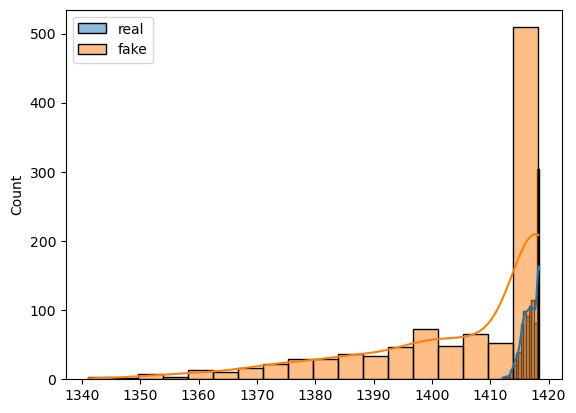

In [28]:
# plot a normal distribution using the mean and std and min and max values of the critic scores
f_scores = np.random.normal(fake_scores.mean(), fake_scores.std(), 1000)
r_scores = np.random.normal(real_scores.mean(), real_scores.std(), 1000)

# Clip the generated scores to the min and max values of the real and fake scores
r_scores = np.clip(r_scores, real_scores.min(), real_scores.max())
f_scores = np.clip(f_scores, fake_scores.min(), fake_scores.max())

sns.histplot(r_scores, label='real', kde=True)
sns.histplot(f_scores, label='fake', kde=True)
plt.legend()

#### compare in time domain

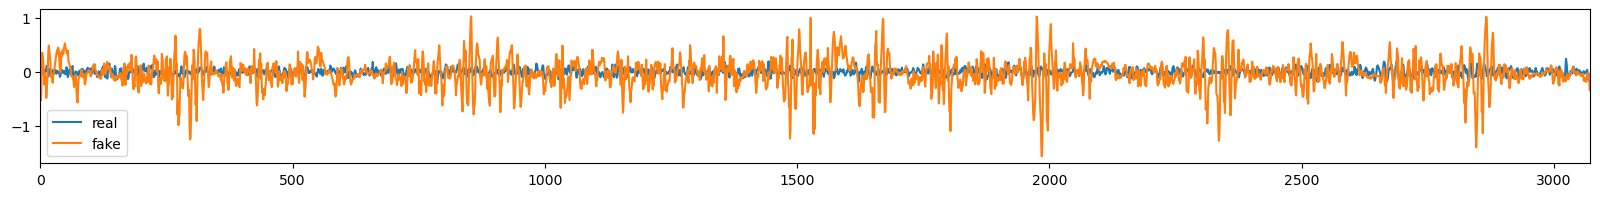

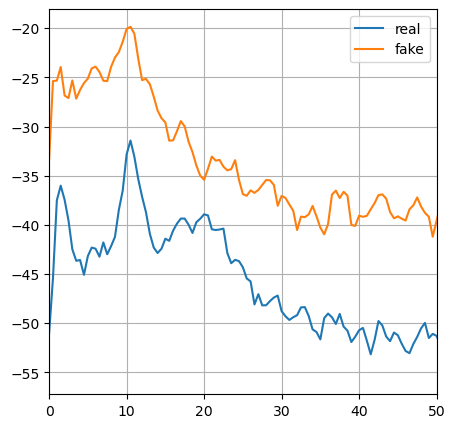

In [104]:
subj = 1
d = 3*1024
s = 3
plot_segment(x, x_gen, subj, s, d, db=True)

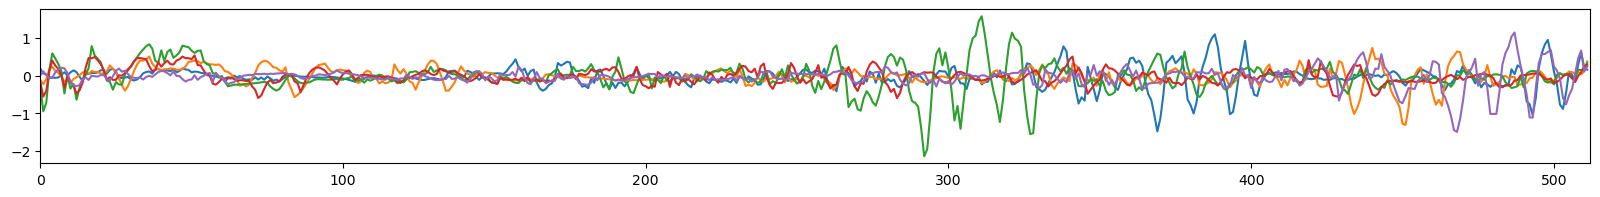

In [101]:
plot_overlap(x_gen, n_seg=5, ch=0, time_dim=512, start_from=100, show=True)

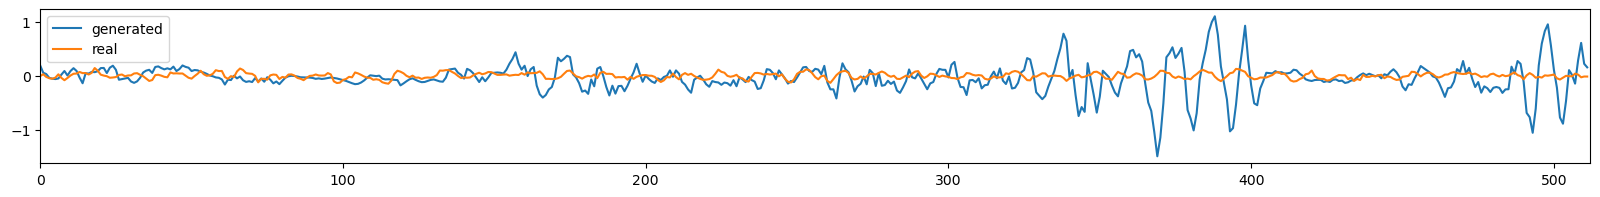

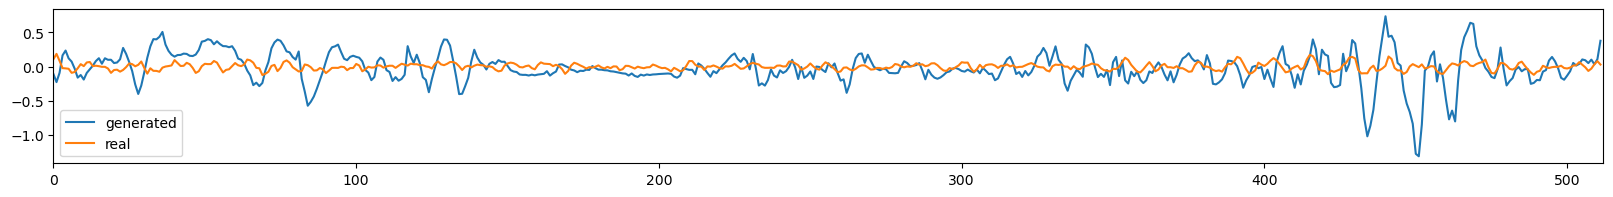

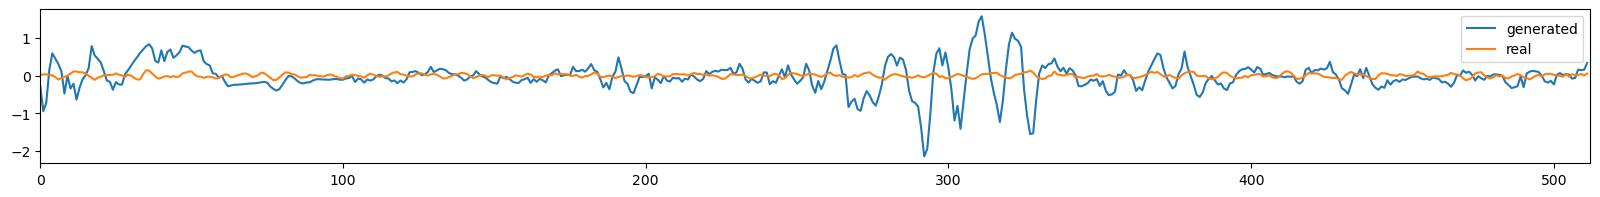

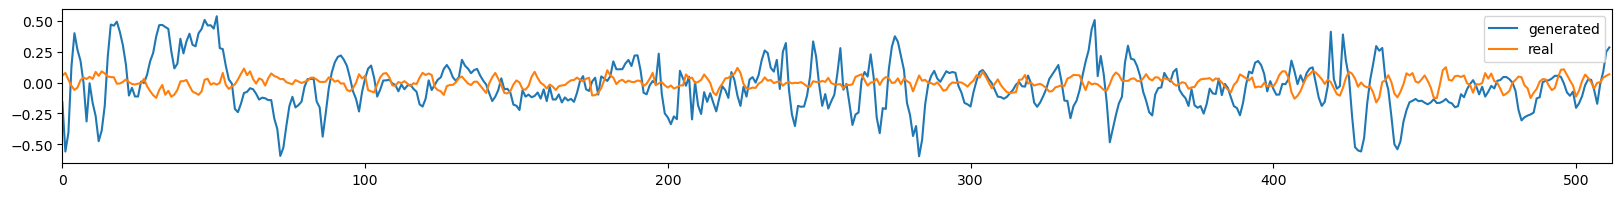

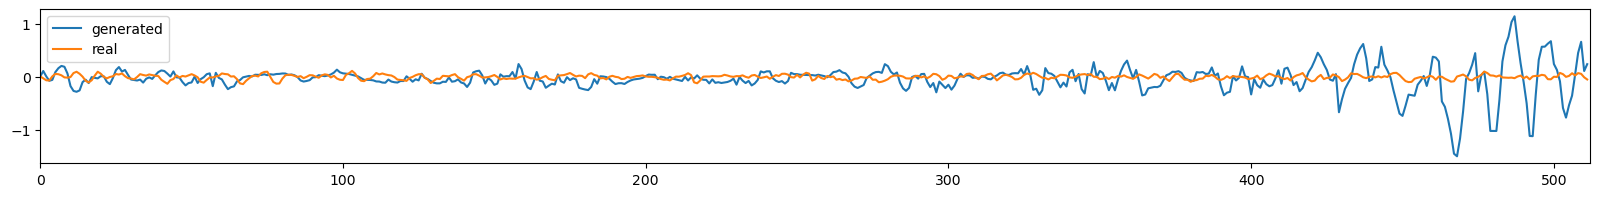

In [102]:
plot_onebyone(x_gen, x, n_seg=5, ch=0, time_dim=512, start_from=100, figsize=(20, 2))

## Modify Architecture

Finding out about the architectural limitations...

In [5]:
load_model = False
i = 160
model_path = f'data/logs/archive_log_11.10.2024/O1/O1_09.10.2024_epoch_{i}.model.keras'

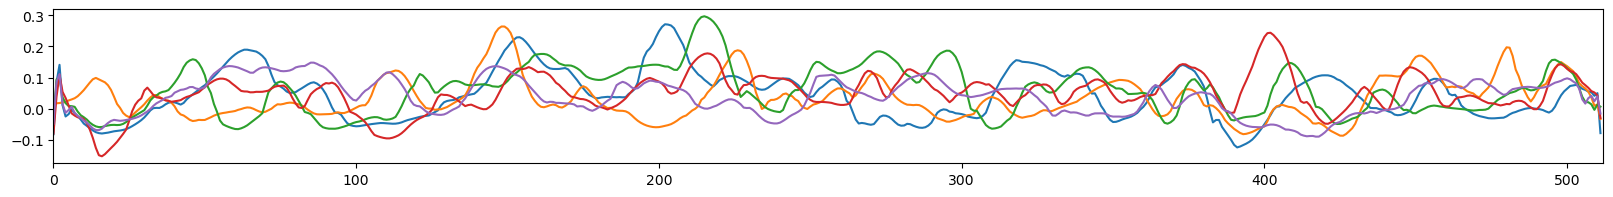

Effective window size : 4.000 (s)


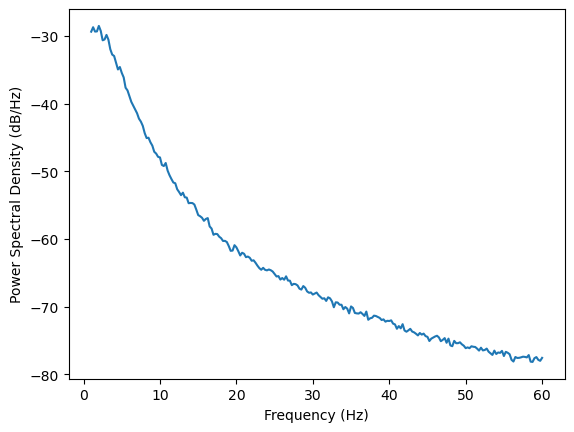

In [6]:
# 2. MODEL and Plot generated data by the model before training
ld = 64
wgan_gp = WGAN_GP(time_dim=512, feature_dim=1, latent_dim=ld, n_subjects=n_subject, use_sublayer_generator=True,
                  use_sublayer_critic=False, use_channel_merger=False, kerner_initializer=keras.initializers.HeNormal(),
                  interpolation='bilinear')

sub2 = np.arange(0, n_subject).reshape(-1, 1)

x_gen = wgan_gp.generator(keras.random.normal((199, ld), mean=x.mean(), stddev=x.std()), torch.tensor(sub2).to('mps'),
                          pos).cpu().detach()

plot_overlap(x_gen, n_seg=5, ch=0, time_dim=512, start_from=100, show=True)
plot_psd(x_gen, label='generated', show=False, db=True)

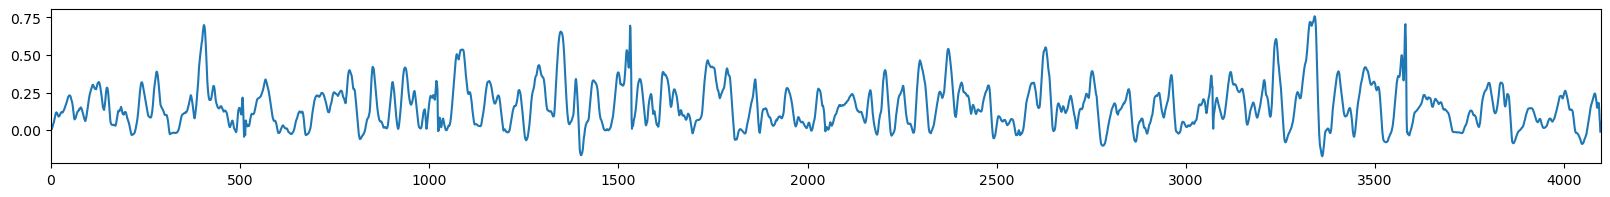

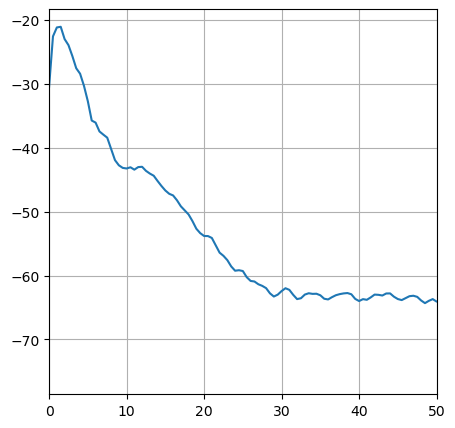

In [32]:
# x_gen = wgan_gp.generator(keras.random.normal((199, ld), mean=x.mean(), stddev=x.std()), torch.tensor(sub2).to('mps'), pos)
# x_gen = x_gen.cpu().detach()
# plot_overlap(x_gen, n_seg=5, ch=0, time_dim=512, start_from=9, show=True)
plot_segment(x_gen, 2, 5, duration=512*8, db=True)
# plot_psd(x_gen, label='generated', show=False, db=True)

In [ ]:
generator = wgan_gp.generator
ly = 18
features = keras.Model(generator.model.layers[0].input, generator.model.layers[ly].output)(keras.random.normal((100, ld), mean=x.mean(), stddev=x.std())).cpu().detach()
print(generator.model.layers[ly].name)

In [68]:
def plot_psd(x, ch=[0], fmin=1, fmax=60, n_fft=512, db=True, ax=None):
    psd, freq = mne.time_frequency.psd_array_welch(x[:, :, ch].flatten().numpy(), sfreq=128, fmin=fmin, fmax=fmax, n_fft=n_fft)
    if db:
        psd = 10*np.log10(psd)
    if ax is not None:
        ax.plot(freq, psd)
        # ax.set_xlabel('Frequency (Hz)')
        # ax.set_ylabel('Power Spectral Density (dB/Hz)')
    else:
        plt.plot(freq, psd,)
        plt.xlabel('Frequency (Hz)')

Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)
Effective window size : 4.000 (s)


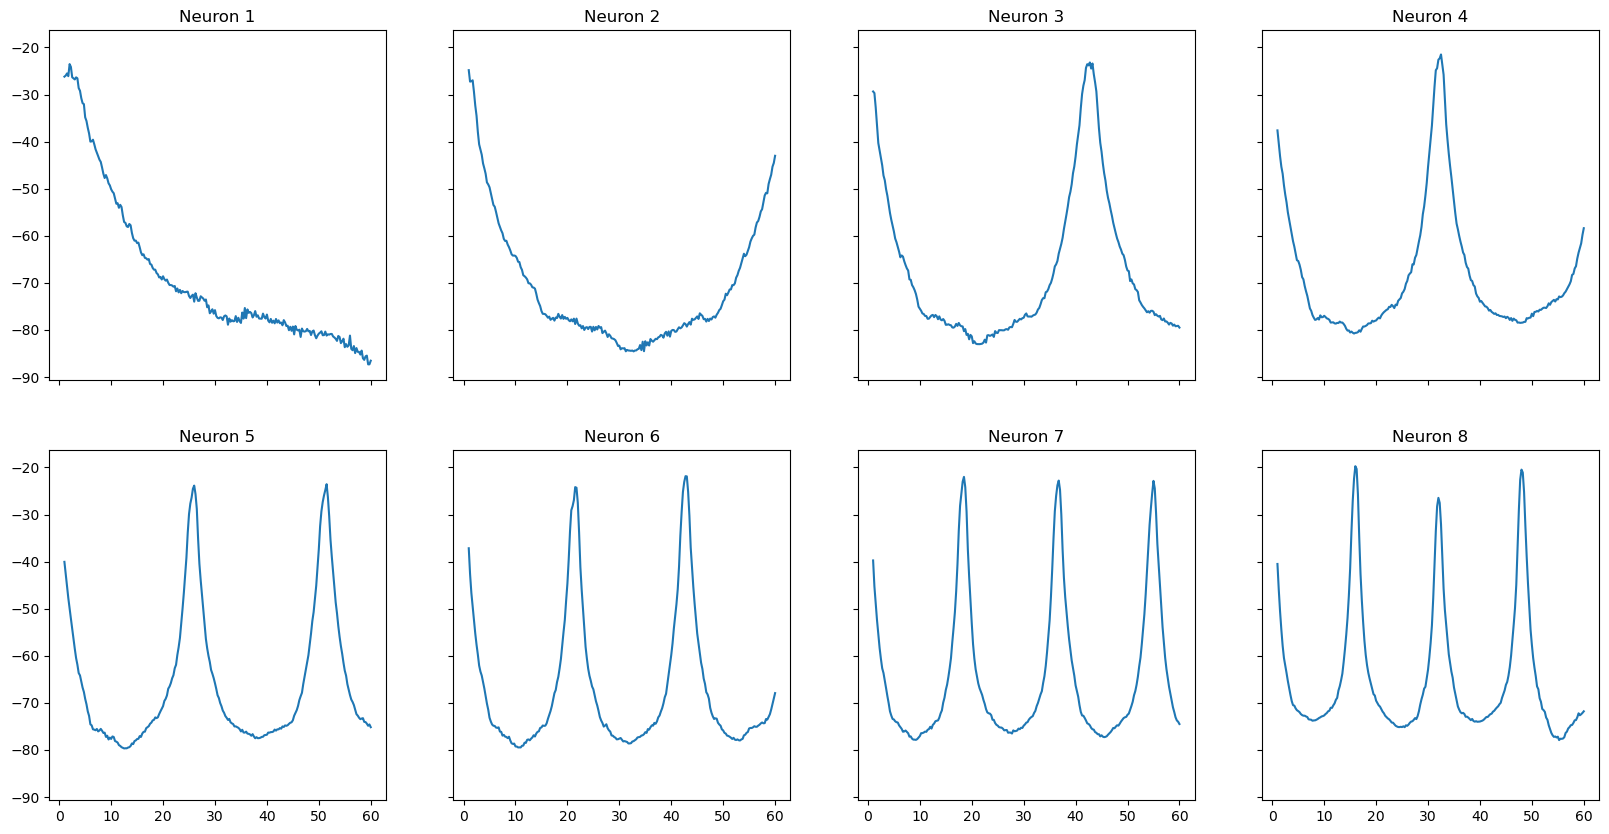

In [69]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharey=True, sharex=True)
ch = [0]
for i in range(8):
    if i != 0:
        ch = ch + [i]
    plot_psd(features, ch=ch, n_fft=512, db=True, ax=axes[i//4, i%4])
    axes[i//4, i%4].set_title(f'Neuron {i+1}')

fig.tight_layout()
fig.title('Power Spectral Density (dB/Hz) of the Neurons')
    # axes[0].set_ylabel('Power Spectral Density (dB/Hz)')

## Improve efficiency of the training

In [27]:
from torch.utils.data import DataLoader, TensorDataset

# data = {'x': x, 'sub': sub, 'pos': pos}
# data = TensorDataset(data['x'], data['sub'], data['pos'])
# data = DataLoader(data, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)

# Custom collate_fn to transfer tensors to the GPU
def collate_fn(batch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(batch[10][2])
    x, sub, pos = batch
    return x.to(device), sub.to(device), pos.to(device)

data = TensorDataset(x, sub, pos)
data = DataLoader(data, batch_size=64, shuffle=True, num_workers=0, pin_memory=True,
                #   collate_fn=collate_fn
                  )

In [28]:
wgan_gp.compile(d_optimizer=keras.optimizers.Adam(0.00005, beta_1=0.5, beta_2=0.9),
                g_optimizer=keras.optimizers.Adam(0.0005, beta_1=0.5, beta_2=0.9),
                gradient_penalty_weight=5.0)

In [30]:
for batch in data:
    x, sub, pos = batch
    print(x.device, sub.device, pos.device)
    break

cpu cpu cpu


In [ ]:
wgan_gp.fit(data, epochs=1, batch_size=64, shuffle=True)

In [20]:
import cProfile, pstats
profiler = cProfile.Profile()
profiler.enable()
wgan_gp.fit(data, epochs=1, batch_size=64, shuffle=True)
profiler.disable()
stats = pstats.Stats(profiler).sort_stats('cumtime')
stats.print_stats(10)  # Print top 10 functions by cumulative time


92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step - _fake_pred: 0.0242 - _real_pred: 0.3112 - critic_grad_norm: 1.0233 - d_loss: 0.2848 - g_loss: 3.3089
         6313848 function calls (6141820 primitive calls) in 14.584 seconds

   Ordered by: cumulative time
   List reduced from 714 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000   14.584    7.292 /opt/homebrew/Caskroom/miniforge/base/envs/EEGModalNet/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3541(run_code)
        2    0.000    0.000   14.584    7.292 {built-in method builtins.exec}
  26129/1    0.025    0.000   14.584   14.584 /opt/homebrew/Caskroom/miniforge/base/envs/EEGModalNet/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py:110(error_handler)
        1    0.002    0.002   14.583   14.583 /opt/homebrew/Caskroom/miniforge/base/envs/EEGModalNet/lib/python3.11/site-packages/keras/src/backend/torch/trainer.py:166(fit)
     

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU],
             schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
             on_trace_ready=None,
            #  record_shapes=True
             ) as prof:
    wgan_gp.fit(data, epochs=1, batch_size=64, shuffle=True)
    print('Model training finished')
print(prof.key_averages().table(sort_by='cpu_time_total', row_limit=10))


69/92 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - _fake_pred: nan - _real_pred: nan - critic_grad_norm: nan - d_loss: nan - g_loss: nan

In [8]:
print(prof.key_averages().table(sort_by='cpu_time_total', row_limit=20))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
enumerate(DataLoader)#_MultiProcessingDataLoaderIter...        21.11%        3.009s        21.12%        3.009s      32.358ms            93  
                                            aten::copy_        13.85%        1.974s        13.94%        1.986s      60.927us         32594  
                                               aten::to         0.05%       6.805ms        13.30%        1.895s      60.882us         31129  
                                         aten::_to_copy         0.07%       9.609ms        13.25%        1.888s     510.102us          3702  
      

In [58]:
positions = torch.randint(0, 20, (20, 2))


In [59]:
import torch
import math
dimension = 256
margin = 0.2
*O, D = positions.shape
n_freqs = (dimension // 2)**0.5
freqs_y = torch.arange(n_freqs, device=positions.device)
freqs_x = freqs_y[:, None]
width = 1 + 2 * margin
positions = positions + margin
p_x = 2 * math.pi * freqs_x / width
p_y = 2 * math.pi * freqs_y / width
positions = positions[..., None, None, :]
loc = (positions[..., 0] * p_x + positions[..., 1] * p_y).view(*O, -1)
emb = torch.cat([
    torch.cos(loc),
    torch.sin(loc),
], dim=-1)

In [9]:
import torch
a = torch.randn(1, 512, 1).half()
b = torch.randn(1, 512, 6).half()
torch.einsum('btd,bto->bod', b, a)

tensor([[[12.3516, 38.5000, 10.5234, 10.0703, 30.5469,  7.7031]]],
       dtype=torch.float16)

In [ ]:
eeg = torch.randn(2, 512, 6)
weights = torch.randn(2, 512, 2)
out = torch.einsum("bct,boc->bot", eeg, weights)

In [31]:
from src.EEGModalNet.models.common import ChannelMerger

cm = ChannelMerger(6, 288)

x_ = x.half()
cm(x_.half(), pos.half()).shape

torch.Size([6000, 6, 512]) torch.Size([6000, 6, 6])


RuntimeError: expected m1 and m2 to have the same dtype, but got: c10::Half != float

In [32]:
pos.dtype

torch.float32